In [1]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot
from collections import defaultdict
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping
from poliastro.extra_util import get_galilean_orbs, ecliptic_slingshot, get_galilean_ephemerides
#from poliastro.extra_util import get_single_burn_elliptical_hohmann
solar_system_ephemeris.set("jpl")

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



<ScienceState solar_system_ephemeris: 'jpl'>

In [16]:
start_date= time.Time("2037-06-11 00:01", scale="utc").tdb
end_date= time.Time("2037-09-21 00:01", scale="utc").tdb
epochs=time_range(start=start_date,end=end_date,periods=50)

callisto_ephem = Ephem.from_horizons(504,epochs= epochs, attractor= Jupiter,plane=Planes.EARTH_ECLIPTIC)#Callisto is 504
callisto_orb= Orbit.from_ephem(attractor=Jupiter,ephem=callisto_ephem,epoch=start_date)


r_perijove = Jupiter.R+230000 * u.km
r_apijove = Jupiter.R+6.5e6*u.km
a_start = (r_perijove+r_apijove)/2
ecc_start = (r_perijove-r_apijove)/(r_perijove+r_apijove)

starship_orb=Orbit.from_classical(
Jupiter, 1242294.17*u.km, 0.89360*u.one
, callisto_orb.inc, 
callisto_orb.raan, 0*u.deg, 180*u.deg,
start_date,plane=Planes.EARTH_ECLIPTIC)
print(starship_orb.period.to(u.day))

ephemerides = get_galilean_ephemerides(start_date, end_date)


ganymede_ephem = ephemerides[Ganymede]
callisto_ephem = ephemerides[Callisto]
galilean_orbs = get_galilean_orbs(start_date,start_date+10*u.day)

ganymede_orb = galilean_orbs[Ganymede]
callisto_orb= Orbit.from_ephem(attractor=Jupiter,ephem=callisto_ephem,epoch=start_date)

8.94525276527237 d


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/astropy/units/decorators.py:302: UserWarning:

Wrapping true anomaly to -π <= nu < π



-180.0 deg
-4.472626382636184 d
8.94525276527237 d


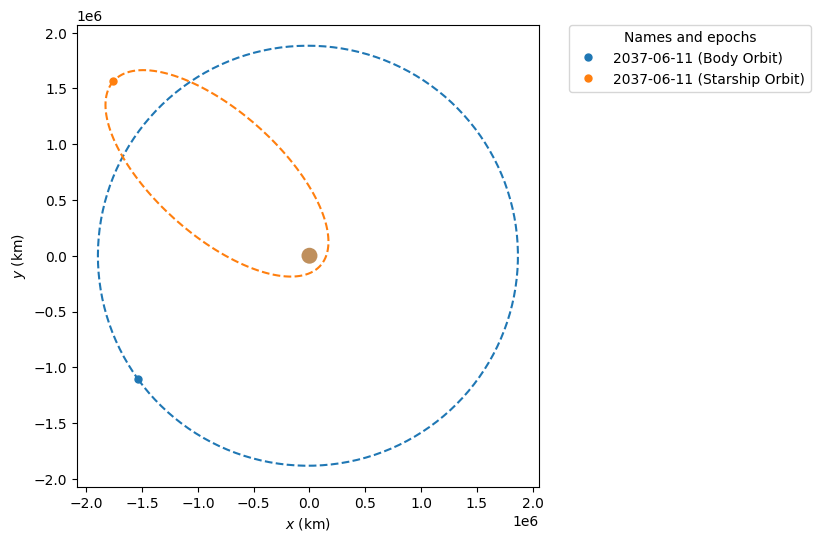

In [15]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(callisto_orb, label="Body Orbit")
plotter.plot(starship_orb, label="Starship Orbit")
print(starship_orb.nu)
print(starship_orb.t_p_dep.to(u.day))
print(starship_orb.period.to(u.day))

In [4]:
def get_single_burn_elliptical_hohmann(target_orb, initial_orb, min_tof=0.1*u.day, max_tof=50*u.day, tof_step=0.1*u.day, retrograde_only=False):
    time_till_pe=initial_orb.t_p
    periapsis_epoch=initial_orb.epoch+time_till_pe
    
    if max_tof<time_till_pe:
        raise ValueError("Max time of flight is less than time till periapsis, no possible transfers.")
    if min_tof<time_till_pe:
        min_tof=time_till_pe+1*u.s
    # plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
    min_dv=50000*u.m/u.s
    final_orb=None
    final_date=None
    final_burn=None
    final_targ_orb=None
    periapsis_orb=initial_orb.propagate(periapsis_epoch)#Orbit at the first periapsis after start date
    body_orb_placeholder = target_orb.propagate(periapsis_epoch)
    
    max_orbits_before_burn=math.floor((max_tof-time_till_pe)/initial_orb.period)
    for k in range(max_orbits_before_burn):
        pre_burn_orbit=periapsis_orb.propagate(initial_orb.period*k)
        tof_range=np.arange(0,(max_tof.to(u.day)-k*initial_orb.period).value,tof_step.to(u.day).value)*u.day
        for i in range(len(tof_range)):
            arrival_date=periapsis_epoch+tof_range[i]
            body_orb=body_orb_placeholder.propagate(arrival_date+1*u.s)
            #try multiple revolutions of lambert arcs
            for j in range(0,3):
                try:
                    lambert=Maneuver.lambert(periapsis_orb,body_orb,M=j)
                    burn=lambert[0]
                    dv=np.linalg.norm(burn[1])
                    #check for retrograde if needed
                    progradeness=np.dot(burn[1].to(u.km/u.s).value,body_orb.v.to(u.km/u.s).value)
                    if retrograde_only and (progradeness)<0:
                        continue
                
                    if dv<min_dv:
                        min_dv=dv
                        final_orb,dummy=periapsis_orb.apply_maneuver(lambert,intermediate=True)
                        final_date=arrival_date
                        final_burn=burn
                        final_targ_orb=body_orb
                        # plotter.plot(final_orb)
                except Exception as e:
                    # print(e)
                    continue
    
    print("Best dv:", min_dv)
        
    return [min_dv,final_orb,final_targ_orb,final_date,final_burn,time_till_pe,periapsis_orb]

In [ ]:
##Incriments spacecraft by tof_step forward and scans over all allowed tofs

def get_single_burn_elliptical_hohmann_brute_force(target_orb, initial_orb,max_depature_wait=50*u.day, min_tof=0.1*u.day, max_tof=50*u.day, tof_step=0.1*u.day, retrograde_only=False,fine_scan=False):
    min_dv=50000*u.m/u.s
    start_epoch=initial_orb.epoch
    final_orb=None
    final_date=None
    final_burn_date=None
    final_targ_orb=None
    final_tof=None
    departure_date_range=np.arange(0,max_depature_wait.to(u.day).value,tof_step.to(u.day).value)*u.day
    tof_range=np.arange(min_tof.to(u.day).value,max_tof.to(u.day).value,tof_step.to(u.day).value)*u.day
    for d in departure_date_range:
        pre_burn_orbit=initial_orb.propagate(d)
        for i in range(len(tof_range)):
            arrival_date=start_epoch+d+tof_range[i]
            body_orb=target_orb.propagate(arrival_date+1*u.s)
            #try multiple revolutions of lambert arcs
            for j in range(0,3):
                try:
                    lambert=Maneuver.lambert(pre_burn_orbit,body_orb,M=j)
                    burn=lambert[0]
                    dv=np.linalg.norm(burn[1])
                    #check for retrograde if needed
                    progradeness=np.dot(burn[1].to(u.km/u.s).value,body_orb.v.to(u.km/u.s).value)
                    if retrograde_only and (progradeness)<0:
                        continue
                
                    if dv<min_dv:
                        min_dv=dv
                        final_orb,dummy=pre_burn_orbit.apply_maneuver(lambert,intermediate=True)
                        final_date=arrival_date
                        final_burn_date=d
                        final_targ_orb=body_orb
                        final_tof=tof_range[i]
                        # plotter.plot(final_orb)
                except Exception as e:
                    # print(e)
                    continue
    results=[min_dv,final_orb,final_targ_orb,final_date,final_burn_date]
    print("Best dv:", min_dv)
    if not fine_scan:
        test_min_tof=final_tof-5*tof_step
        test_max_tof=final_tof+5*tof_step
        test_max_depature_wait=final_burn_date
        transfer=get_single_burn_elliptical_hohmann_brute_force(
            ganymede_orb,
            starship_orb,
            max_depature_wait=test_max_depature_wait,
            min_tof=test_min_tof,
            max_tof=test_max_tof,
            tof_step=tof_step/10,
            retrograde_only=retrograde_only,
            fine_scan=True
            
        )
        results=transfer
    return results

In [ ]:
transfer=get_single_burn_elliptical_hohmann_brute_force(
    ganymede_orb,
    starship_orb,
    max_depature_wait=5*u.day,
    tof_step=0.1*u.day,
    min_tof=10*u.day,
    max_tof=20*u.day,
    retrograde_only=True
)


Best dv: 188.70972725296863 m / s


In [6]:
starship_flyby_orbit=transfer[1]#.propagate(transfer[2].epoch)
body_flyby_orbit=transfer[2]

In [7]:
print(f"Dv is {transfer[0]}, time of flight is {(-transfer[5]+transfer[3]-starship_orb.epoch).to(u.day):.2f} from perijove")
print(f"Flyby at {body_flyby_orbit.epoch}, speed {np.linalg.norm(body_flyby_orbit.v-starship_flyby_orbit.v)}")

Dv is 300.8139610173318 m / s, time of flight is 33.80 d from perijove
Flyby at 2037-07-14 19:14:10.185, speed 35.21820384110523 km / s


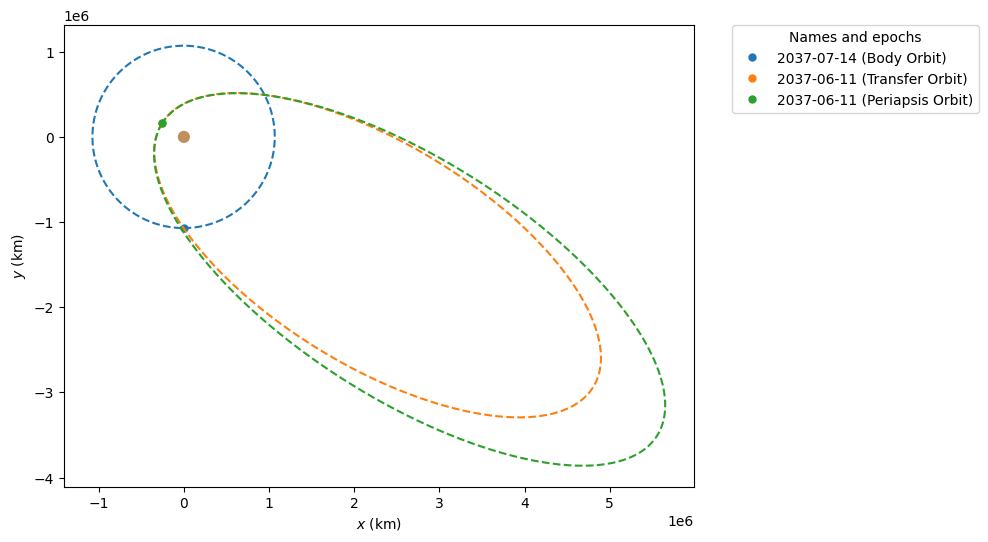

In [8]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
plotter.plot(body_flyby_orbit, label="Body Orbit")
# plotter.plot(starship_orb, label="Starship Orbit")
plotter.plot(starship_flyby_orbit, label="Transfer Orbit")
plotter.plot(transfer[-1], label="Periapsis Orbit")